In [1]:
import pandas as pd
import re
import numpy as np
import os
import seaborn as sns

import sys
sys.path.append("../../../src/main/python")
import plots

# Number of row in data tables

In [2]:

datafiles = os.listdir("../../JoCI/models/synthetic/s1/")
datafiles = filter(re.compile("random_mc2_n[0-9]*_mid3_d1000_05_mr098_r10_[0-9]*\.csv").match, datafiles)
files = list(datafiles)
s=[pd.read_csv("../../JoCI/models/synthetic/s1/"+f).shape[0] for f in files]
datasize = pd.DataFrame({'file':files, "size":s})
datasize['file'] = datasize.file.str[:-3] + "uai"
pd.Series(s).describe()

count     369.000000
mean     1589.430894
std       941.998310
min      1000.000000
25%      1000.000000
50%      1000.000000
75%      2000.000000
max      5500.000000
dtype: float64

(array([207.,  57.,  47.,  18.,  10.,  10.,   9.,   4.,   5.,   2.]),
 array([1000., 1450., 1900., 2350., 2800., 3250., 3700., 4150., 4600.,
        5050., 5500.]),
 <BarContainer object of 10 artists>)

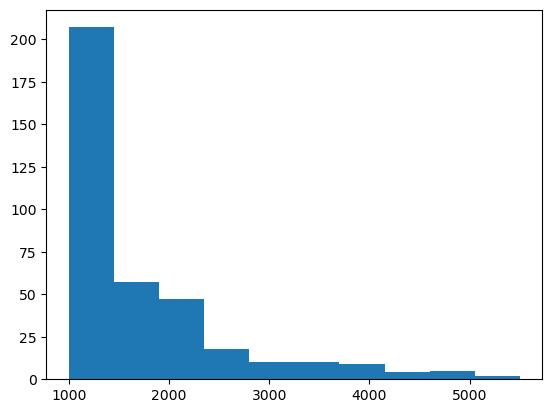

In [3]:
import matplotlib.pyplot as plt
plt.hist(s)

# Experiment results

In [379]:
data = pd.read_csv("full_fixed_output.csv.bz2", header=None, names=["file",
            'memory', 'cntx-switch', 'page-faults', 'wall-clock', 'system-time',
            'user-time', 'cpu', 'modelpath', 'datapath', 'maxLL', 'maxIter',
            'numRuns', 'threads', 'seed', 'method', 'methodCode', 'forceTable',
            'components', 'FullLikelihoods', 'FullCircuitSize', 'FullCompileTime',
            'FullEMCCRunTimes', 'CCCount', 'CCLikelihoods', 'CCCircuitSizes',
            'CCCompileTimes', 'CCEMCCRunTimes', 'runtime', 'cause', 'effect', 'pU'
        ])

data.loc[(data.components) & (data.methodCode==5), "CCCircuitSizes"] = data.loc[(data.components) & (data.methodCode==5), "CCCircuitSizes"].str.split(";").apply(lambda x:np.array(x, int))
data.loc[(data.components) & (data.methodCode==5), "CCCompileTimes"] = data.loc[(data.components) & (data.methodCode==5), "CCCompileTimes"].str.split(";").apply(lambda x:np.array(x, int))
data.loc[(~data.CCEMCCRunTimes.isna()),"CCEMCCRunTimes"]=data.loc[(~data.CCEMCCRunTimes.isna())].CCEMCCRunTimes.str.split(";").apply(lambda x:np.array([ i.split("|") for i in x], int))


data.loc[~data.FullEMCCRunTimes.isna(), "FullEMCCRunTimes"] = data.loc[~data.FullEMCCRunTimes.isna()].FullEMCCRunTimes.str.split("|").apply(lambda x:np.array(x, int))

data['file'] = data.file.str[len("../JoCI/models/synthetic/s1/"):]

data = data.merge(datasize, on="file")
data_orig = data

In [403]:

def loadInfo(row):
    file=row['file']
    d = pd.read_csv("../../JoCI/models/synthetic/s1/" + file[:-4]+"_info.csv")
    d['file'] = file
    d['dag_size'] = d.dag.apply(lambda x:len(x.split("]")[0][2:].split("  ")))
    return d.iloc[0]


info = data_orig[['file']].drop_duplicates().apply(loadInfo, axis=1)
data=  data_orig.merge(info, on="file", how="left").copy()

In [404]:
data.shape

(2952, 50)

In [405]:
dm2cc = data[(~data.runtime.isna()) & (data.methodCode==2) & (data.components==True) & (data.threads==1)].set_index("file")
dm2ccmt = data[(~data.runtime.isna()) & (data.methodCode==2) & (data.components==True) & (data.threads>1)].set_index("file")
dm2full = data[(~data.runtime.isna()) & (data.methodCode==2) & (data.components==False)].set_index("file")

dm5cc = data[(~data.runtime.isna()) & (data.methodCode==5) & (data.components==True) & (data.threads==1) & (data.forceTable==True)].set_index("file")
dm5ccmt = data[(~data.runtime.isna()) & (data.methodCode==5) & (data.components==True) & (data.threads>1) & (data.forceTable==True)].set_index("file")
dm5full = data[(~data.runtime.isna()) & (data.methodCode==5) & (data.components==False) & (data.forceTable==True)].set_index("file")

mapping = {"dm2cc" :"BN CC", "dm2ccmt":"BN MT", "dm5full":"KC", "dm5cc":"KC CC", "dm5ccmt":"KC MT"}
order = [
    #"dm2full", 
    "dm2cc", "dm2ccmt", "dm5full", "dm5cc", "dm5ccmt"]

In [407]:

dfs = {
    #"dm2full":dm2full,
    "dm2cc":dm2cc,"dm2ccmt":dm2ccmt,"dm5cc":dm5cc,"dm5ccmt":dm5ccmt,"dm5full":dm5full}

dfs2 = {
    k:
    dfs[k].rename({c: c + "_" + k for c in dfs[k].columns }, axis=1)
for k in dfs.keys()}

import functools

xz_out = functools.reduce(lambda a,b : pd.merge(a,b, on="file", how="outer"), dfs2.values()).copy()
xz_in = functools.reduce(lambda a,b : pd.merge(a,b, on="file", how="inner"), dfs2.values()).copy()


for k in dfs2.keys():
    xz_in[f"rel_{k}"] = xz_in[f"runtime_{k}"]/xz_in[f"runtime_dm2cc"]

/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_84129/508546276.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  xz_out = functools.reduce(lambda a,b : pd.merge(a,b, on="file", how="outer"), dfs2.values()).copy()
/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_84129/508546276.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  xz_in = functools.reduce(lambda a,b : pd.merge(a,b, on="file", how="inner"), dfs2.values()).copy()


### Boxplot of relative network runtimes

In [410]:
xz_in.dag_size_dm2cc

file
random_mc2_n5_mid3_d1000_05_mr098_r10_70.uai      6
random_mc2_n9_mid3_d1000_05_mr098_r10_90.uai     12
random_mc2_n8_mid3_d1000_05_mr098_r10_98.uai     11
random_mc2_n10_mid3_d1000_05_mr098_r10_72.uai    15
random_mc2_n7_mid3_d1000_05_mr098_r10_5.uai      11
                                                 ..
random_mc2_n5_mid3_d1000_05_mr098_r10_47.uai      5
random_mc2_n6_mid3_d1000_05_mr098_r10_68.uai      9
random_mc2_n7_mid3_d1000_05_mr098_r10_75.uai     10
random_mc2_n7_mid3_d1000_05_mr098_r10_6.uai      11
random_mc2_n5_mid3_d1000_05_mr098_r10_72.uai      6
Name: dag_size_dm2cc, Length: 335, dtype: int64

In [411]:
relbx = xz_in[[f"rel_{k}" for k in dfs2.keys()]][[f"rel_{o}" for o in order[::-1]]].rename({f"rel_{k}":mapping[k] for k in dfs2.keys()}, axis=1).drop(['BN CC'], axis=1)
p = plots.boxplots_cols(relbx, relbx.columns)
def convert(data):
    return f"""\\addplot+[
    boxplot prepared={{
      median={data.q50 },
      upper quartile={data.q75},
      lower quartile={data.q25},
      upper whisker={data['min']},
      lower whisker={data['max']}
    }},
    ] coordinates {{}};
    """

tiks= ",".join([ str(i+1) for i in range(p.shape[0])])
pcol=",".join([str(c) for c in p.iloc[:,0].values])
print(f"[\nxtick={{{tiks}}},\nxticklabels={{{pcol}}}\n]")
print("\n".join(p.apply(convert, axis=1).values))

KeyError: "['dag_size_dm5cc'] not in index"

In [111]:
test = "wall-clock"
gt = pd.DataFrame([
    [ 
        sum(xz_in[f"{test}_{y}"] > xz_in[f"{test}_{x}"]) if x != y else ""
        for x in dfs2.keys() 
    ]
    for y in dfs2.keys()
], index=dfs2.keys(), columns=dfs2.keys())



rows = ["dm2ccmt", "dm5full", "dm5cc", "dm5ccmt"]
cols = ["dm2cc", "dm2ccmt", "dm5full", "dm5cc"]

print(gt.loc[order, order].rename(mapping, axis=1).rename(mapping, axis=0).to_latex())

\begin{tabular}{llllll}
\toprule
{} & BN CC & BN MT &   KC & KC CC & KC MT \\
\midrule
BN CC &       &   335 &  313 &   335 &   335 \\
BN MT &     0 &       &  206 &   333 &   335 \\
KC    &    22 &   129 &      &   290 &   331 \\
KC CC &     0 &     2 &   45 &       &   331 \\
KC MT &     0 &     0 &    4 &     4 &       \\
\bottomrule
\end{tabular}



/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_84129/2485577005.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(gt.loc[order, order].rename(mapping, axis=1).rename(mapping, axis=0).to_latex())


In [285]:
runtimes = pd.DataFrame({
    "dm5ccmt":dm5ccmt.runtime/ dm2cc.runtime,
    "dm5cc":dm5cc.runtime/dm2cc.runtime,
    "dm5full":dm5full.runtime/dm2cc.runtime,
    "dm2ccmt":dm2ccmt.runtime/dm2cc.runtime,
    #"dm2cc":dm2cc.runtime/dm2cc.runtime,
#    "dm2full":dm2full.runtime,
}).rename(mapping, axis=1)

In [368]:
rts

,KC MT,KC CC,KC,BN MT
file,,,,
random_mc2_n10_mid3_d1000_05_mr098_r10_10.uai,0.056351,0.117660,0.507130,0.412129
random_mc2_n10_mid3_d1000_05_mr098_r10_13.uai,0.307908,0.385741,1.921465,0.340189
random_mc2_n10_mid3_d1000_05_mr098_r10_24.uai,0.057792,0.115064,0.828512,0.289657
random_mc2_n10_mid3_d1000_05_mr098_r10_27.uai,0.050243,0.155983,1.417515,0.277845
random_mc2_n10_mid3_d1000_05_mr098_r10_29.uai,0.036036,0.124885,0.803400,0.249363
...,...,...,...,...
random_mc2_n9_mid3_d1000_05_mr098_r10_90.uai,0.043599,0.153757,0.426555,0.304805
random_mc2_n9_mid3_d1000_05_mr098_r10_91.uai,0.042110,0.148407,0.548844,0.287637
random_mc2_n9_mid3_d1000_05_mr098_r10_92.uai,0.054186,0.114474,0.492449,0.376767


(335, 4)

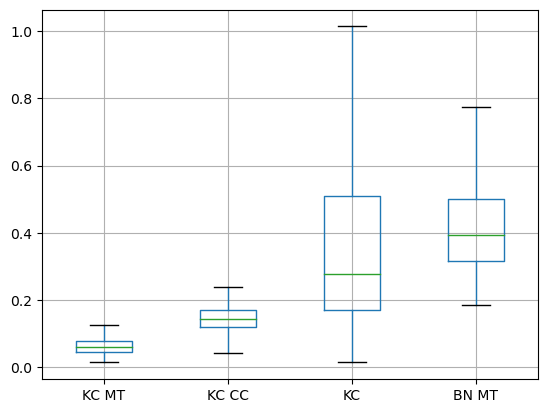

In [286]:
rts = runtimes[~(runtimes.isna().any(axis=1))]
rts.boxplot(showfliers=False)

rts.shape

In [114]:
p = plots.boxplots_cols(rts, runtimes.columns)

In [115]:
def convert(data):
    return f"""\\addplot+[
    boxplot prepared={{
      median={data.q50 / 1000.0},
      upper quartile={data.q75/ 1000.0},
      lower quartile={data.q25/ 1000.0},
      upper whisker={data['min']/ 1000.0},
      lower whisker={data['max']/ 1000.0}
    }},
    ] coordinates {{}};
    """

tiks= ",".join([ str(i+1) for i in range(p.shape[0])])
pcol=",".join([str(c) for c in p.iloc[:,0].values])
print(f"[\nxtick={{{tiks}}},\nxticklabels={{{pcol}}}\n]")
print("\n".join(p.apply(convert, axis=1).values))

[
xtick={1,2,3,4,5},
xticklabels={KC MT,KC CC,KC,BN MT,BN CC}
]
\addplot+[
    boxplot prepared={
      median=8.007,
      upper quartile=10.2965,
      lower quartile=6.3545,
      upper whisker=2.699,
      lower whisker=13.842
    },
    ] coordinates {};
    
\addplot+[
    boxplot prepared={
      median=18.938,
      upper quartile=29.3865,
      lower quartile=12.7805,
      upper whisker=4.767,
      lower whisker=43.773
    },
    ] coordinates {};
    
\addplot+[
    boxplot prepared={
      median=37.369,
      upper quartile=101.007,
      lower quartile=16.436,
      upper whisker=4.237,
      lower whisker=163.738
    },
    ] coordinates {};
    
\addplot+[
    boxplot prepared={
      median=52.072,
      upper quartile=83.864,
      lower quartile=37.993,
      upper whisker=13.722,
      lower whisker=115.101
    },
    ] coordinates {};
    
\addplot+[
    boxplot prepared={
      median=150.757,
      upper quartile=229.3865,
      lower quartile=94.4835,
      upp

### Plot total runtimes against BN CC

In [325]:
methods = ["dm2", "dm5"]
def variant(methods, variant):
    return [m + variant for m in methods]

In [334]:
refruntime.shape

(335,)

/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_84129/376053601.py:34: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cpu_x', 'threads_x', 'FullCompileTime_x', 'runtime_x', 'pU_x', 'user-time_x', 'cntx-switch_x', 'numRuns_x', 'method_x', 'datapath_x', 'CCEMCCRunTimes_x', 'page-faults_x', 'components_x', 'CCCount_x', 'system-time_x', 'size_x', 'effect_x', 'methodCode_x', 'relRuntime_x', 'FullLikelihoods_x', 'CCLikelihoods_x', 'CCCircuitSizes_x', 'FullCircuitSize_x', 'CCCompileTimes_x', 'memory_x', 'seed_x', 'FullEMCCRunTimes_x', 'maxLL_x', 'wall-clock_x', 'maxIter_x', 'cause_x', 'forceTable_x', 'modelpath_x'} in the result is deprecated and will raise a MergeError in a future version.
  x = pd.merge(x,
/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_84129/376053601.py:39: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ref_rRuntime_x'} in the result is deprecated and will raise a MergeError in a future version.
  x = pd.merge(x,

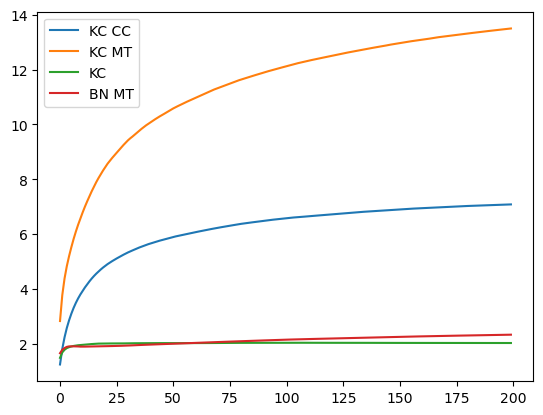

In [346]:
dm2cc["rRuntime"] = dm2cc.CCEMCCRunTimes.apply(lambda x: np.apply_over_axes(sum, x, axes=[0])[0])
dm5cc["rRuntime"] = dm5cc.CCEMCCRunTimes.apply(lambda x: np.apply_over_axes(sum, x, axes=[0])[0])
dm2ccmt["rRuntime"] = dm2ccmt.CCEMCCRunTimes.apply(lambda x: np.apply_over_axes(np.max, x, axes=[0])[0])
dm5ccmt["rRuntime"] = dm5ccmt.CCEMCCRunTimes.apply(lambda x: np.apply_over_axes(np.max, x, axes=[0])[0])
dm2full["rRuntime"] = dm2full.FullEMCCRunTimes
dm5full["rRuntime"] = dm5full.FullEMCCRunTimes

dm2cc['relRuntime'] = dm5cc.apply(lambda r: r.rRuntime / r.rRuntime, axis=1)

dm5cc["ref_rRuntime"] = dm2cc["rRuntime"]
dm5cc['relRuntime'] = dm5cc.apply(lambda r: r.rRuntime / r.ref_rRuntime, axis=1)

dm5ccmt["ref_rRuntime"] = dm2cc["rRuntime"]
dm5ccmt['relRuntime'] = dm5ccmt.apply(lambda r: r.rRuntime / r.ref_rRuntime, axis=1)

dm2ccmt["ref_rRuntime"] = dm2cc["rRuntime"]
dm2ccmt['relRuntime'] = dm2ccmt.apply(lambda r: r.rRuntime / r.ref_rRuntime, axis=1)

dm5full["ref_rRuntime"] = dm2cc["rRuntime"]
dm5full['relRuntime'] = dm5full.apply(lambda r: r.rRuntime / r.ref_rRuntime, axis=1)

c = "rRuntime"
x = pd.merge(
    dm5cc.rename({c:"KC CC"}, axis=1),
    dm2cc.rename({c:"BN CC"}, axis=1),
    how="inner", 
    on="file"
)
x = pd.merge(x,
    dm2ccmt.rename({c:"BN MT"}, axis=1),
    how="inner", 
    on="file"
)
x = pd.merge(x,
    dm5ccmt.rename({c:"KC MT"}, axis=1),
    how="inner", 
    on="file"
)
x = pd.merge(x,
    dm5full.rename({c:"KC"}, axis=1),
    how="inner", 
    on="file"
)
mb = functools.reduce(np.add, x["BN CC"])
methods = ["KC CC", "KC MT", "KC", "BN MT"]
for xx in methods:
    m1 = functools.reduce(np.add, x[xx])
    plt.plot(mb/m1, label=xx)

outdata = np.array([mb/functools.reduce(np.add, x[xx]) for xx in methods])
plt.legend()
plt.show()
x.shape
pd.DataFrame(outdata.T, columns = methods).to_csv("ratios.csv")

In [347]:
pd.DataFrame(outdata.T, columns = methods)

,KC CC,KC MT,KC,BN MT
0,1.253200,2.836583,1.494874,1.663671
1,1.821885,3.782086,1.692915,1.789337
2,2.243543,4.388450,1.789171,1.852002
3,2.584289,4.837256,1.849673,1.895439
4,2.863449,5.202293,1.883819,1.912069
...,...,...,...,...
195,7.075755,13.462848,2.035524,2.332787
196,7.078202,13.472162,2.035360,2.334253
197,7.081051,13.481107,2.035372,2.335762
198,7.083802,13.489651,2.035408,2.337389


### Save data as csv

In [144]:
ratios = np.array([ functools.reduce(np.add, x[xx])/mb for xx in methods])
pd.DataFrame(ratios.T, columns = methods).to_csv("ratios.csv")

### Network stats

In [154]:
info.describe()

,avg_endo_indegree,avg_exo_card,avg_indegree,datasize,endo_tw,exo_tw,markovianity,max_exo_card,num_exo_vars,ratio,tw
count,335.000000,335.000000,335.000000,335.000000,295.000000,335.000000,335.000000,335.000000,335.000000,335.000000,251.000000
mean,1.060270,11.073962,1.161001,1579.104478,1.928814,1.280597,1.125373,29.591045,4.534328,0.988967,2.900398
std,0.294806,11.706865,0.135510,931.250096,0.621347,0.475835,0.630403,56.545328,1.714115,0.013877,0.483777
min,0.000000,2.500000,0.800000,1000.000000,0.000000,1.000000,0.000000,3.000000,2.000000,0.897600,2.000000
25%,0.800000,6.000000,1.074176,1000.000000,2.000000,1.000000,1.000000,8.000000,3.000000,0.986363,3.000000
50%,1.142857,8.400000,1.176471,1000.000000,2.000000,1.000000,1.000000,16.000000,4.000000,0.992637,3.000000
75%,1.285714,10.666667,1.269697,2000.000000,2.000000,2.000000,2.000000,16.000000,6.000000,0.996355,3.000000
max,1.666667,93.333333,1.500000,5500.000000,3.000000,3.000000,2.000000,256.000000,10.000000,0.999683,4.000000


In [156]:
asize = info.dag.apply(lambda x:len(x.split("]")[0][2:].split("  "))).mean()
minsize = info.dag.apply(lambda x:len(x.split("]")[0][2:].split("  "))).min()
maxsize = info.dag.apply(lambda x:len(x.split("]")[0][2:].split("  "))).max()

print(f"Average DAG size: {asize} - {minsize} - {maxsize}")
print(f"Average EXO count: {info.num_exo_vars.mean()}")

Average DAG size: 9.871641791044777 - 5 - 21
Average EXO count: 4.534328358208955


In [202]:
info.dag

file
random_mc2_n5_mid3_d1000_05_mr098_r10_70.uai     ([0  1  2  3  4  5]  [(1 0)  (3 0)  (4 0)  (3 ...
random_mc2_n9_mid3_d1000_05_mr098_r10_90.uai     ([0  1  2  3  4  5  6  7  8  9  10  11]  [(8 0...
random_mc2_n8_mid3_d1000_05_mr098_r10_98.uai     ([0  1  2  3  4  5  6  7  8  9  10]  [(0 1)  (...
random_mc2_n10_mid3_d1000_05_mr098_r10_72.uai    ([0  1  2  3  4  5  6  7  8  9  10  11  12  13...
random_mc2_n7_mid3_d1000_05_mr098_r10_5.uai      ([0  1  2  3  4  5  6  7  8  9  10]  [(1 0)  (...
                                                                       ...                        
random_mc2_n5_mid3_d1000_05_mr098_r10_47.uai     ([0  1  2  3  4]  [(0 2)  (1 3)  (2 3)  (4 3) ...
random_mc2_n6_mid3_d1000_05_mr098_r10_68.uai     ([0  1  2  3  4  5  6  7  8]  [(3 0)  (0 1)  (...
random_mc2_n7_mid3_d1000_05_mr098_r10_75.uai     ([0  1  2  3  4  5  6  7  8  9]  [(6 0)  (7 0)...
random_mc2_n7_mid3_d1000_05_mr098_r10_6.uai      ([0  1  2  3  4  5  6  7  8  9  10]  [(1 0)  (...
rando

In [240]:
def tomap(d):
    for x in d:
        print(x)

ab  = pd.DataFrame({"to":info.dag.str.extractall('(\([0-9]* [0-9]*\))').iloc[:,0].str[1:-1].str.split(" ").apply(lambda x:x[-1])})
ab['value'] = 1

In [280]:
rnd = functools.partial(np.round, decimals=1)

In [359]:
out = ""
out = out + "DAG size & " +  " & ".join(info.dag.apply(lambda x:len(x.split("]")[0][2:].split("  "))).describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Exogenous variables & " + " & ".join(info.num_exo_vars.describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Exogenous Cardinalities & " + " & ".join(info.max_exo_card.describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Treewidth & " + " & ".join(info.tw.describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Max Indegree & " + " & ".join(ab.groupby(["file", "to"]).agg("count").groupby("file").agg("max").describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values[:,0]) + " \\\\\n"
out = out + "Circuit size & " + " & ".join(xz_in.FullCircuitSize_dm5full.describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Components & " + " & ".join(xz_in.CCCount_dm5full.describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Max Circuit Size & " + " & ".join(xz_in.CCCircuitSizes_dm5cc.apply(max).describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"
out = out + "Max Relative Circuit Size & " + " & ".join((xz_in.CCCircuitSizes_dm5cc.apply(max)/xz_in.FullCircuitSize_dm5full).describe().loc[["min","max", "mean"]].apply(rnd).astype(str).values) + " \\\\\n"

print(out)

DAG size & 5.0 & 21.0 & 9.9 \\
Exogenous variables & 2.0 & 10.0 & 4.5 \\
Exogenous Cardinalities & 3.0 & 256.0 & 29.6 \\
Treewidth & 2.0 & 4.0 & 2.9 \\
Max Indegree & 2.0 & 4.0 & 3.0 \\
Circuit size & 38.0 & 6064.0 & 688.3 \\
Components & 1.0 & 10.0 & 4.2 \\
Max Circuit Size & 20.0 & 5016.0 & 449.8 \\
Max Relative Circuit Size & 0.2 & 1.8 & 0.6 \\



In [367]:
xx = (xz_in.CCCircuitSizes_dm5cc.apply(max)/xz_in.FullCircuitSize_dm5full)
xx[~xx.isna()]


file
random_mc2_n5_mid3_d1000_05_mr098_r10_70.uai     0.658537
random_mc2_n9_mid3_d1000_05_mr098_r10_90.uai     0.510490
random_mc2_n8_mid3_d1000_05_mr098_r10_98.uai     0.302721
random_mc2_n10_mid3_d1000_05_mr098_r10_72.uai    0.252125
random_mc2_n7_mid3_d1000_05_mr098_r10_5.uai      0.386957
                                                   ...   
random_mc2_n5_mid3_d1000_05_mr098_r10_47.uai     0.885714
random_mc2_n6_mid3_d1000_05_mr098_r10_68.uai     0.594406
random_mc2_n7_mid3_d1000_05_mr098_r10_75.uai     0.589404
random_mc2_n7_mid3_d1000_05_mr098_r10_6.uai      0.395745
random_mc2_n5_mid3_d1000_05_mr098_r10_72.uai     0.647059
Length: 335, dtype: float64

In [356]:
xz_in.CCCircuitSizes_dm5cc.apply(max)

file
random_mc2_n5_mid3_d1000_05_mr098_r10_70.uai     108
random_mc2_n9_mid3_d1000_05_mr098_r10_90.uai     292
random_mc2_n8_mid3_d1000_05_mr098_r10_98.uai     178
random_mc2_n10_mid3_d1000_05_mr098_r10_72.uai    178
random_mc2_n7_mid3_d1000_05_mr098_r10_5.uai      178
                                                ... 
random_mc2_n5_mid3_d1000_05_mr098_r10_47.uai      62
random_mc2_n6_mid3_d1000_05_mr098_r10_68.uai     170
random_mc2_n7_mid3_d1000_05_mr098_r10_75.uai     178
random_mc2_n7_mid3_d1000_05_mr098_r10_6.uai      186
random_mc2_n5_mid3_d1000_05_mr098_r10_72.uai      66
Name: CCCircuitSizes_dm5cc, Length: 335, dtype: int64

DAG size & 5 & 21 & 9.9 \\
Exogenous Vars count & 2 & 10 & 4.5 \\
SCM Treewidth & 2 & 4 & 2.9 \\
Max Indegree & 2 & 4 & 3 \\


info